# Model Development

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

In [50]:
# Replace with the path to Chicago dataset
chicago_filepath = "Chicago_after_FE.csv"
# Replace with the path to NIBRS test dataset
NIBRS_filepath = "NIBRS_after_FE.csv"

# Read the dataset
chicago_df = pd.read_csv(chicago_filepath)
NIBRS_df = pd.read_csv(NIBRS_filepath)

/var/folders/gv/4cnh8blj2mgcj1tbxqms_3yw0000gn/T/ipykernel_16174/3116578832.py:8: DtypeWarning: Columns (8,9,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  NIBRS_df = pd.read_csv(NIBRS_filepath)


In [51]:
# Check Date Range
c_min_date = chicago_df['date'].min()
c_max_date = chicago_df['date'].max()
n_min_date = NIBRS_df['date'].min()
n_max_date = NIBRS_df['date'].max()
print(f"Chicago Dataset Date Range: {c_min_date} to {c_max_date}")
print(f"NIBRS Dataset Date Range: {n_min_date} to {n_max_date}")

Chicago Dataset Date Range: 2020-07-31 17:29:00 to 2025-03-16 03:00:00
NIBRS Dataset Date Range: 2023-01-01 00:00:00 to 2023-12-31 23:00:00


In [52]:
chicago_df['date'] = pd.to_datetime(chicago_df['date'])
# Choose data from 2021-01-01 to 2022-12-31 for model training and initial testing
filtered_df = chicago_df[(chicago_df['date'] >= '2021-01-01') & (chicago_df['date'] <= '2022-12-31')]

print(f"Chicago Dataset Date Range After Filtering: {filtered_df['date'].min()}, {filtered_df['date'].max()}")

Chicago Dataset Date Range After Filtering: 2021-01-01 00:00:00, 2022-12-31 00:00:00


In [53]:
chicago_df = filtered_df
print("Chicago dataset shape:", chicago_df.shape)

Chicago dataset shape: (448489, 32)


In [54]:
NIBRS_df.shape

(562976, 37)

In [55]:
feature_columns = [
    'arrest', 'UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday',
    'is_weekend', 'is_holiday', 'crime_against', 'offense_category_name'
]

chicago_df = chicago_df[feature_columns]

In [56]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [57]:
X = chicago_df.drop(columns=['arrest'])
y = chicago_df['arrest']

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
print(type(y_test), len(y_test))

<class 'pandas.core.series.Series'> 89698


In [59]:
y_test.isna().sum()

0

In [60]:
# this for record metric of different model
report_dfs = {}
combined_report_df = pd.DataFrame()

In [61]:
# this for recording prediction results of different models
chicago_predictions = pd.DataFrame(columns=["y_true", "CatBoost", "RandomForest", "LogisticRegression"])
nibrs_predictions = pd.DataFrame(columns=["y_true", "CatBoost", "RandomForest", "LogisticRegression"])

In [62]:
chicago_predictions = pd.concat([X_test, chicago_predictions], axis=1)

## Model Training

## CatBoost Model:
- Handles categorical data well: CatBoost is great at working with categorical features **without needing much preprocessing**, which saves time and effort.
- Reduces overfitting: It has built-in tools to prevent overfitting, making predictions more reliable, especially with complex datasets like crime data.
- Strong performance: It often outperforms other models like decision trees or random forests, giving you accurate arrest predictions.

In [63]:
y_train.value_counts()

arrest
False    315072
True      43719
Name: count, dtype: int64

For `arrest` feature, it is extremely imbalanced with highly unarrested proportion.

`Catboost` can handle this with set `scale_pos_weight`  = # of False/ # of True.

In [64]:
arrest_weight = int(y_train.value_counts()[0] / y_train.value_counts()[1])
arrest_weight

7

In [65]:
# indicate categorical features
cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    scale_pos_weight=arrest_weight,  # improve the importance of Arrest=True
    early_stopping_rounds=50,
    eval_metric='F1',  # better evaluation metric for imbalanced data
    verbose=100,
    random_state=42
)
# Train the model
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), use_best_model=True)
# Predict
y_pred = model.predict(X_test)

# Evaluate the model
print("Chicago Classification Report:\n", classification_report(y_test, y_pred))


report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['Chicago - CatBoost'] = report_df

# Add model name as column for stacking
report_df['model'] = 'Chicago - CatBoost'
combined_report_df = pd.concat([combined_report_df, report_df])

0:	learn: 0.6910929	test: 0.6915118	best: 0.6915118 (0)	total: 158ms	remaining: 2m 37s
100:	learn: 0.7425227	test: 0.7418607	best: 0.7432042 (52)	total: 8.35s	remaining: 1m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7432041643
bestIteration = 52

Shrink model to first 53 iterations.
Chicago Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.81      0.88     78768
        True       0.34      0.71      0.46     10930

    accuracy                           0.80     89698
   macro avg       0.65      0.76      0.67     89698
weighted avg       0.88      0.80      0.83     89698



Text(0.5, 1.0, 'Catboost Feature Importance')

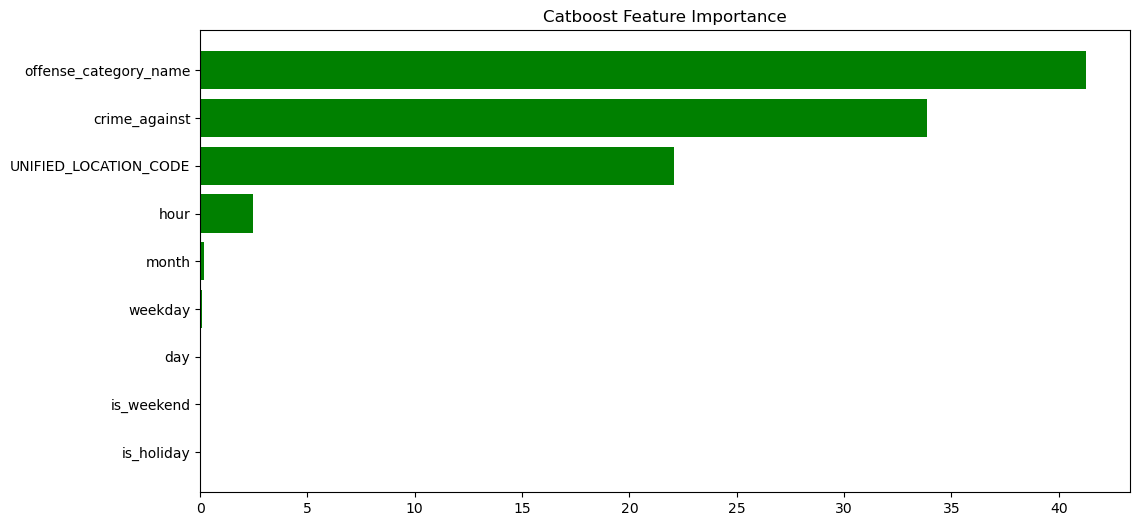

In [66]:
catboost_feature_importance = model.feature_importances_
sorted_idx = np.argsort(catboost_feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), catboost_feature_importance[sorted_idx], align='center', color='green')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Catboost Feature Importance')

In [67]:
chicago_predictions.loc[:, "y_true"] = y_test
chicago_predictions.loc[:, "CatBoost"] = y_pred

### Test Model In NIBRS

In [68]:
NIBRS_df = NIBRS_df[feature_columns]
NIBRS_df.head()

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
0,True,1,1,19,21,3,0,0,Person,Assault Offenses
1,True,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property
2,True,1,4,13,13,3,0,0,Person,Assault Offenses
3,True,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses
4,True,1,5,20,15,5,1,0,Person,Assault Offenses


In [69]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [70]:
X_NIBRS_test = NIBRS_df.drop(columns=['arrest'])
y_NIBRS_test = NIBRS_df['arrest']

In [71]:
# Keep the same columns sequences as in the training set
X_NIBRS_test = X_NIBRS_test[X_train.columns]

y_NIBRS_pred = model.predict(X_NIBRS_test)

print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

report_dict = classification_report(y_NIBRS_test, y_NIBRS_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['NIBRS - CatBoost'] = report_df

# Add model name as column for stacking
report_df['model'] = 'NIBRS - CatBoost'
combined_report_df = pd.concat([combined_report_df, report_df])

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.75      0.82    467171
        True       0.33      0.59      0.42     95805

    accuracy                           0.72    562976
   macro avg       0.61      0.67      0.62    562976
weighted avg       0.80      0.72      0.75    562976



In [72]:
nibrs_predictions = pd.concat([X_NIBRS_test, nibrs_predictions], axis=1)

In [73]:
print(nibrs_predictions.shape)
print(len(y_NIBRS_test))
print(len(y_NIBRS_pred))

(562976, 13)
562976
562976


In [74]:
nibrs_predictions.loc[:, "y_true"] = y_NIBRS_test   
nibrs_predictions.loc[:, "CatBoost"] = y_NIBRS_pred

## Random forest Model

In [75]:
# Check data types of all columns
print(chicago_df.dtypes)

# Check for non-numeric columns
non_numeric_columns = chicago_df.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

arrest                     bool
UNIFIED_LOCATION_CODE     int64
month                     int64
day                       int64
hour                      int64
weekday                   int64
is_weekend                int64
is_holiday                int64
crime_against            object
offense_category_name    object
dtype: object
Index(['arrest', 'crime_against', 'offense_category_name'], dtype='object')


In [76]:
label_encoder = LabelEncoder()
chicago_df['crime_against']= label_encoder.fit_transform(chicago_df['crime_against'])
chicago_df['offense_category_name']= label_encoder.fit_transform(chicago_df['offense_category_name'])

In [77]:
X = chicago_df.drop(columns=['arrest'])
y = chicago_df['arrest']

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [78]:
y_test.isna().sum()

0

* Random forests are great for handling imbalanced datasets.


* Set class_weight='balanced' to handle the imbalance by adjusting the weight of the classes in the tree.



In [79]:
# Handle class imbalance using SMOTE ONLY on the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [80]:
# Initialize and train your model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Predict and evaluate on the unmodified test set
y_pred = rf_model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['Chicago - RandomForest'] = report_df

# Add model name as column for stacking
report_df['model'] = 'Chicago - RandomForest'
combined_report_df = pd.concat([combined_report_df, report_df])

              precision    recall  f1-score   support

       False       0.93      0.87      0.90     78768
        True       0.37      0.55      0.44     10930

    accuracy                           0.83     89698
   macro avg       0.65      0.71      0.67     89698
weighted avg       0.86      0.83      0.84     89698

[[68526 10242]
 [ 4914  6016]]


Text(0.5, 1.0, 'Random Forest Feature Importance')

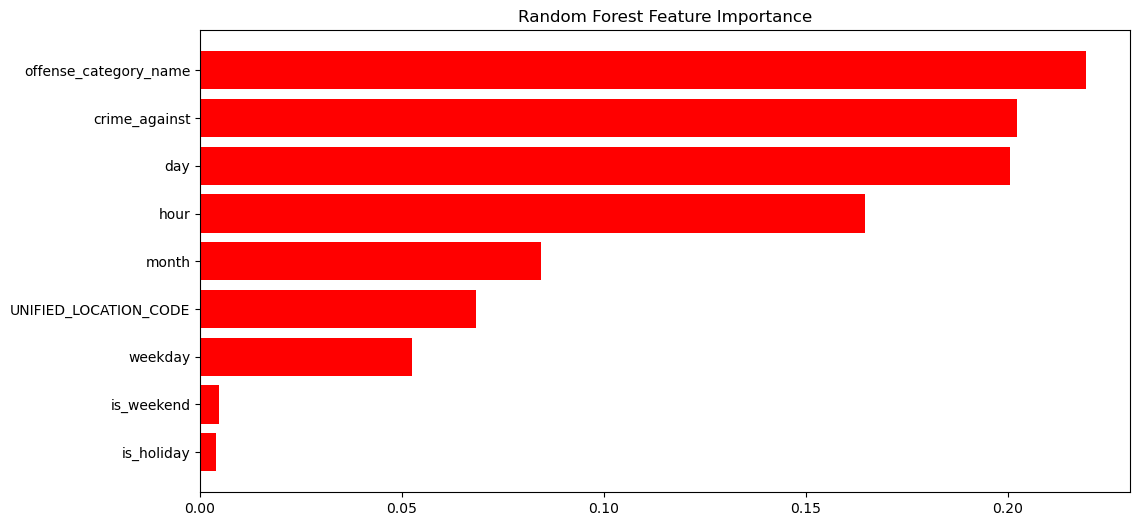

In [103]:

rf_feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(rf_feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), rf_feature_importance[sorted_idx], align='center', color='red')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Random Forest Feature Importance')


In [82]:
# Check where they differ
y_true = chicago_predictions['y_true'].reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

print(type(y_true), len(y_true))
print(type(y_test_reset), len(y_test_reset))

diff = y_true != y_test_reset

# View mismatches
print("Are they completely equal?", (~diff).all())
print("Mismatched rows:", diff.sum())
print("Sample mismatches:")
print(y_true[diff])
print(y_test_reset[diff])


<class 'pandas.core.series.Series'> 89698
<class 'pandas.core.series.Series'> 89698
Are they completely equal? True
Mismatched rows: 0
Sample mismatches:
Series([], Name: y_true, dtype: object)
Series([], Name: arrest, dtype: bool)


In [83]:
chicago_predictions.loc[:, "RandomForest"] = y_pred

### Test Model in NIBRS

In [84]:
NIBRS_df = NIBRS_df[feature_columns]
NIBRS_df.head()

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
0,True,1,1,19,21,3,0,0,Person,Assault Offenses
1,True,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property
2,True,1,4,13,13,3,0,0,Person,Assault Offenses
3,True,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses
4,True,1,5,20,15,5,1,0,Person,Assault Offenses


In [85]:
label_encoder = LabelEncoder()
NIBRS_df['crime_against']= label_encoder.fit_transform(NIBRS_df['crime_against'])
NIBRS_df['offense_category_name']= label_encoder.fit_transform(NIBRS_df['offense_category_name'])

In [86]:
X_NIBRS_test = NIBRS_df.drop(columns=['arrest'])
y_NIBRS_test = NIBRS_df['arrest']

In [87]:
# Keep the same columns sequences as in the training set
X_NIBRS_test = X_NIBRS_test[X_train.columns]

y_NIBRS_pred = rf_model.predict(X_NIBRS_test)

print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))
report_dict = classification_report(y_NIBRS_test, y_NIBRS_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['NIBRS - RandomForest'] = report_df

# Add model name as column for stacking
report_df['model'] = 'NIBRS - RandomForest'
combined_report_df = pd.concat([combined_report_df, report_df])

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.33      0.49    467171
        True       0.20      0.82      0.32     95805

    accuracy                           0.42    562976
   macro avg       0.55      0.58      0.41    562976
weighted avg       0.78      0.42      0.46    562976



In [88]:
# Check where they differ
y_true = nibrs_predictions['y_true'].reset_index(drop=True)
y_test_reset = y_NIBRS_test.reset_index(drop=True)

print(type(y_true), len(y_true))
print(type(y_test_reset), len(y_test_reset))

diff = y_true != y_test_reset

# View mismatches
print("Are they completely equal?", (~diff).all())
print("Mismatched rows:", diff.sum())


<class 'pandas.core.series.Series'> 562976
<class 'pandas.core.series.Series'> 562976
Are they completely equal? True
Mismatched rows: 0


In [89]:
nibrs_predictions.loc[:, "RandomForest"] = y_NIBRS_pred

## Logistic Regression with SGDClassifier

The Logistic Regression model was selected for this arrest prediction task due to its distinct advantages in handling the given feature space (crime type, time, and location) and its fundamental algorithmic differences from the previously attempted CatBoost model.  

**Key Justifications:**  
1. **Interpretability**: Logistic Regression provides clear insights into the relationship between features and the target variable, making it easier to understand how different factors influence arrest probabilities.
2. **Simplicity**: The model's straightforward nature allows for efficient training and evaluation, especially in scenarios with a large number of features.
3. **Performance**: Logistic Regression is known for its robustness and effectiveness in binary classification tasks, particularly when the relationship between features and the target variable is approximately linear.
4. **Scalability**: The model can handle large datasets efficiently, making it suitable for the volume of data in this project.
5. **Regularization**: Logistic Regression can incorporate regularization techniques (L1 and L2) to prevent overfitting, which is crucial given the potential complexity of the feature space.
6. **Baseline Comparison**: Using Logistic Regression allows for a clear baseline to compare against more complex models, such as CatBoost, ensuring that any improvements in performance can be attributed to the model's complexity rather than the feature set.

### Imbalanced data
For `arrest` feature, it is extremely imbalanced with highly unarrested proportion.

We will use `SGDClassifier` with `log` loss function. The `log` loss function is used for binary classification problems and is suitable for our task of predicting arrests. The `SGDClassifier` is a linear classifier that uses stochastic gradient descent to optimize the model parameters. It is efficient for large datasets and can handle online learning scenarios.


In [90]:
# Define feature types
numeric_features = ['UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday']
binary_features = ['is_weekend', 'is_holiday']
categorical_features = ['crime_against', 'offense_category_name']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('binary', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Define the model pipeline
# Using SGDClassifier with log loss for binary classification
# SGDClassifier is a linear classifier that uses stochastic gradient descent
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        loss='log_loss',
        class_weight={False: 2, True: 8},
        penalty='l2',
        alpha=0.001,
        # class_weight='balanced',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

# Split the data into features and target variable
X = chicago_df.drop(columns=['arrest'])
y = chicago_df['arrest']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train, y_train)


y_scores = model.decision_function(X_test)

# Optimal threshold calculation based on F1 score
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
# print("original performance\n", "Precision: ", precision, "Recall: ",recall,"thresholds: ", thresholds)

optimal_idx = np.argmax(2 * precision * recall / (precision + recall))  # F1 score
optimal_threshold = thresholds[optimal_idx]

# Optimal threshold
print("Optimal Threshold:", optimal_threshold)
y_pred_optimized = (y_scores > optimal_threshold).astype(int)

print("Classification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_optimized))

print("\nConfusion Matrix (Optimized Threshold):")
print(confusion_matrix(y_test, y_pred_optimized))

report_dict = classification_report(y_test, y_pred_optimized, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['Chicago - SGDClassifier'] = report_df

# Add model name as column for stacking
report_df['model'] = 'Chicago - SGDClassifier'
combined_report_df = pd.concat([combined_report_df, report_df])

Optimal Threshold: 0.5686959523903102
Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

       False       0.93      0.97      0.95     78768
        True       0.69      0.46      0.55     10930

    accuracy                           0.91     89698
   macro avg       0.81      0.72      0.75     89698
weighted avg       0.90      0.91      0.90     89698


Confusion Matrix (Optimized Threshold):
[[76502  2266]
 [ 5911  5019]]


{'num__UNIFIED_LOCATION_CODE': 'UNIFIED_LOCATION_CODE', 'num__month': 'month', 'num__day': 'day', 'num__hour': 'hour', 'num__weekday': 'weekday', 'binary__is_weekend': 'is_weekend', 'binary__is_holiday': 'is_holiday', 'cat__crime_against_0': 'crime_against_0', 'cat__crime_against_1': 'crime_against_1', 'cat__crime_against_2': 'crime_against_2', 'cat__crime_against_3': 'crime_against_3', 'cat__offense_category_name_0': 'offense_category_name_0', 'cat__offense_category_name_1': 'offense_category_name_1', 'cat__offense_category_name_2': 'offense_category_name_2', 'cat__offense_category_name_3': 'offense_category_name_3', 'cat__offense_category_name_4': 'offense_category_name_4', 'cat__offense_category_name_5': 'offense_category_name_5', 'cat__offense_category_name_6': 'offense_category_name_6', 'cat__offense_category_name_7': 'offense_category_name_7', 'cat__offense_category_name_8': 'offense_category_name_8', 'cat__offense_category_name_9': 'offense_category_name_9', 'cat__offense_catego

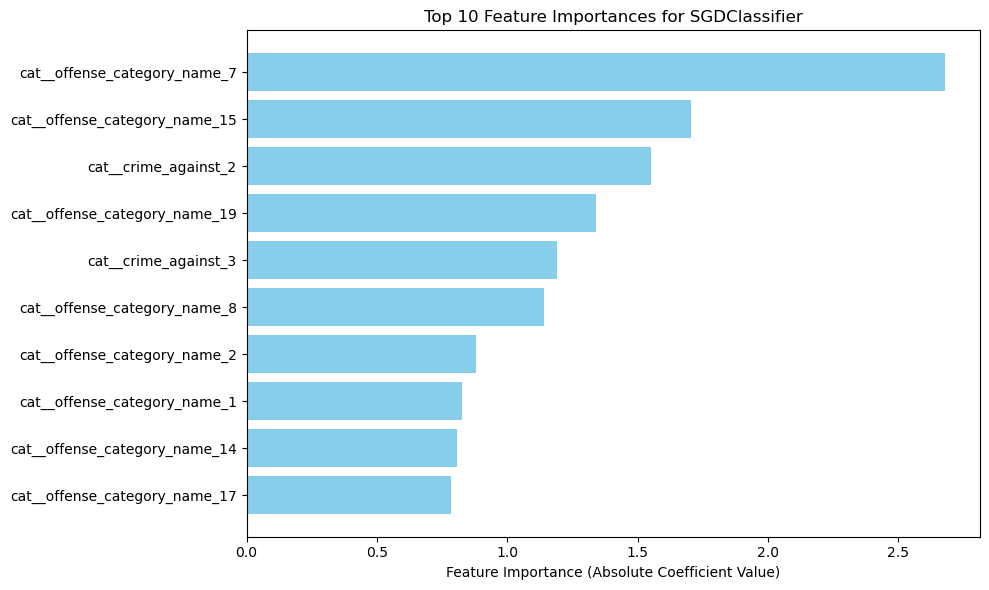

In [91]:
# Step 1: Extract the classifier from the pipeline
classifier = model.named_steps['classifier']

# Step 2: Get the coefficients
# For binary classification, coef_ is a 1D array; for multiclass, it's 2D
coefs = classifier.coef_
if coefs.ndim > 1:  # If multiclass, take the mean across classes
    coefs = np.mean(np.abs(coefs), axis=0)
else:
    coefs = np.abs(coefs)

# Step 3: Get feature names from the preprocessor
# Assuming preprocessor is a ColumnTransformer or similar
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Map categorical feature names
cat_transformer = preprocessor.named_transformers_['cat']
cat_cols = [f"{cat}_{val}" for cat, vals in zip(categorical_features, cat_transformer.categories_) for val in vals]
name_mapping = {
    name: orig for name, orig in zip(feature_names, numeric_features + binary_features + cat_cols)
}
print(name_mapping)
# Step 4: Create a DataFrame for sorting and plotting
import pandas as pd
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefs
}).sort_values(by='Importance', ascending=False)

# Step 5: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10], color='skyblue')
plt.xlabel('Feature Importance (Absolute Coefficient Value)')
plt.title('Top 10 Feature Importances for SGDClassifier')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [92]:
# Check where they differ
y_true = chicago_predictions['y_true'].reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

print(type(y_true), len(y_true))
print(type(y_test_reset), len(y_test_reset))

diff = y_true != y_test_reset

# View mismatches
print("Are they completely equal?", (~diff).all())
print("Mismatched rows:", diff.sum())


<class 'pandas.core.series.Series'> 89698
<class 'pandas.core.series.Series'> 89698
Are they completely equal? True
Mismatched rows: 0


In [93]:
chicago_predictions.loc[:, "LogisticRegression"] = y_pred_optimized


In [94]:
import joblib

# Save the trained model to a file
model_filename = "log_regression.pkl"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

"""
Test the saved model with the NIBRS dataset (for merged testing)

# Load the model from the file
loaded_model = joblib.load(model_filename)
print("Model loaded from file.")
# Test the loaded model with the test set
y_pred_loaded = loaded_model.predict(X_test)
print("Loaded Model Classification Report:")
"""

Model saved to log_regression.pkl


'\nTest the saved model with the NIBRS dataset (for merged testing)\n\n# Load the model from the file\nloaded_model = joblib.load(model_filename)\nprint("Model loaded from file.")\n# Test the loaded model with the test set\ny_pred_loaded = loaded_model.predict(X_test)\nprint("Loaded Model Classification Report:")\n'

In [95]:
# param_dist = {
#     'depth': [4, 6],
#     'learning_rate': [0.03, 0.05],
#     'l2_leaf_reg': [3, 5, 7],
#     'scale_pos_weight': [arrest_weight, arrest_weight * 1.5],
#     'border_count': [32, 64]
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='f1',
#     cv=2,
#     verbose=1,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print("Best Params:", random_search.best_params_)

### Test Model In NIBRS

In [96]:
NIBRS_df = NIBRS_df[feature_columns]
NIBRS_df.head()

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
0,True,1,1,19,21,3,0,0,0,2
1,True,1,2,8,18,2,0,0,1,6
2,True,1,4,13,13,3,0,0,0,2
3,True,2,4,13,21,3,0,0,2,7
4,True,1,5,20,15,5,1,0,0,2


In [97]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [98]:
X_NIBRS_test = NIBRS_df.drop(columns=['arrest'])
y_NIBRS_test = NIBRS_df['arrest']

In [99]:
# Keep the same columns sequences as in the training set
X_NIBRS_test = X_NIBRS_test[X_train.columns]

y_NIBRS_pred = model.predict(X_NIBRS_test)

print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

report_dict = classification_report(y_NIBRS_test, y_NIBRS_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['NIBRS - SGDClassifier'] = report_df

# Add model name as column for stacking
report_df['model'] = 'NIBRS - SGDClassifier'
combined_report_df = pd.concat([combined_report_df, report_df])

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.32      0.47    467171
        True       0.19      0.76      0.30     95805

    accuracy                           0.40    562976
   macro avg       0.53      0.54      0.39    562976
weighted avg       0.75      0.40      0.44    562976



In [100]:
# Check where they differ
y_true = nibrs_predictions['y_true'].reset_index(drop=True)
y_test_reset = y_NIBRS_test.reset_index(drop=True)

print(type(y_true), len(y_true))
print(type(y_test_reset), len(y_test_reset))

diff = y_true != y_test_reset

# View mismatches
print("Are they completely equal?", (~diff).all())
print("Mismatched rows:", diff.sum())


<class 'pandas.core.series.Series'> 562976
<class 'pandas.core.series.Series'> 562976
Are they completely equal? True
Mismatched rows: 0


In [101]:
nibrs_predictions.loc[:, "LogisticRegression"] = y_NIBRS_pred

### Save Model Prediction Results

In [102]:
chicago_predictions.to_csv("Evaluation/chicago_predictions.csv", index=False)
nibrs_predictions.to_csv("Evaluation/nibrs_predictions.csv", index=False)
combined_report_df.to_csv("Evaluation/model_metrics_report.csv", index=False)